In [1]:
import gdown
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, learning_curve
from scipy.sparse import hstack
from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer

tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [2]:
# Download dataset
file_id = '1KabcfQ_NQe8-rzgq4P-AnkubUmrvN-nq'
output_path = 'fake_reviews_dataset.csv'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1KabcfQ_NQe8-rzgq4P-AnkubUmrvN-nq
To: /content/fake_reviews_dataset.csv
100%|██████████| 15.3M/15.3M [00:00<00:00, 74.5MB/s]


'fake_reviews_dataset.csv'

label
1    20216
0    20216
Name: count, dtype: int64


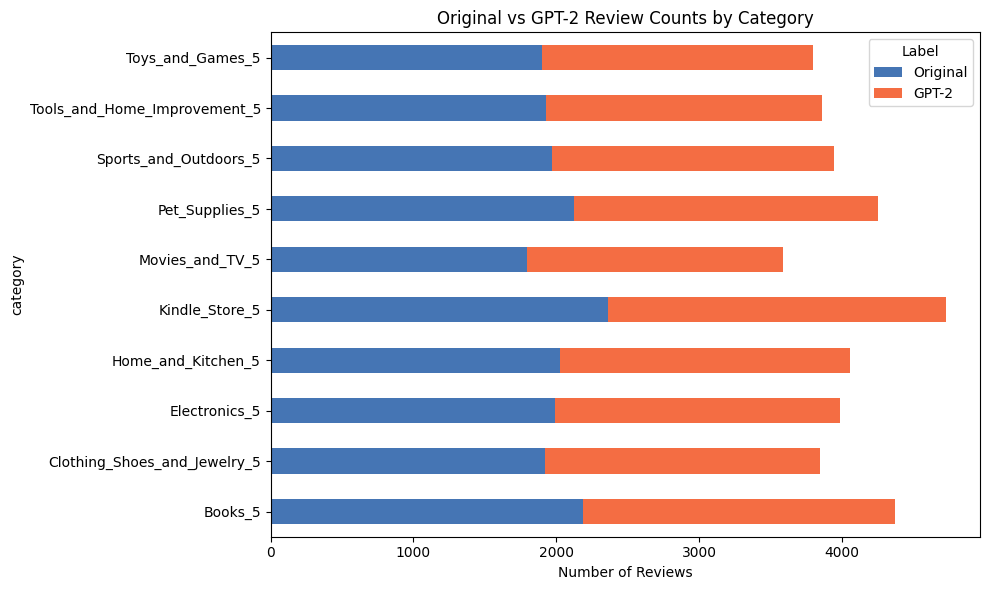

In [3]:
# Load and clean dataset
df = pd.read_csv('fake_reviews_dataset.csv')
df = df.rename(columns={'text_': 'text'})
df['label'] = df['label'].map({'OR': 0, 'CG': 1})
df = df.dropna(subset=['text', 'label', 'category'])

print(df['label'].value_counts())  # Label distribution

# Group and plot
df.groupby(['category', 'label']).size().unstack(fill_value=0).plot(
    kind='barh', stacked=True, figsize=(10, 6),
    color=['#4575b4', '#f46d43'], legend=False
)

plt.xlabel('Number of Reviews')
plt.title('Original vs GPT-2 Review Counts by Category')
plt.legend(['Original', 'GPT-2'], title='Label')
plt.tight_layout()
plt.show()

Train samples: 32345, Validation samples: 8087


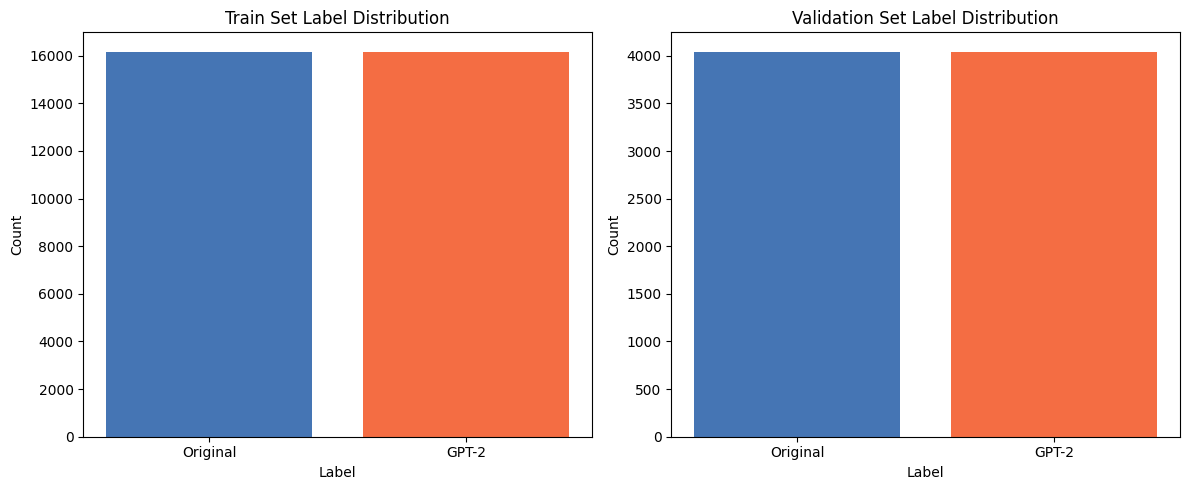

In [4]:
# Split the dataset with stratified labels
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
y_train, y_val = train_df['label'].values, val_df['label'].values

print(f"Train samples: {len(train_df)}, Validation samples: {len(val_df)}")

# Plot label distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, split_df, title in zip(axes, [train_df, val_df], ['Train Set', 'Validation Set']):
    counts = split_df['label'].value_counts().sort_index()
    ax.bar(counts.index, counts.values, color=['#4575b4', '#f46d43'])
    ax.set_title(f'{title} Label Distribution')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Original', 'GPT-2'])
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [5]:
# Convert text into TF-IDF features, including unigrams and bigrams, with a max of 5000 features
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(train_df['text'])
X_val_tfidf = tfidf.transform(val_df['text'])

# Add review length (character count) as an additional numeric feature
train_df['length'] = train_df['text'].apply(len)
val_df['length'] = val_df['text'].apply(len)

# Normalize review length
scaler = MinMaxScaler()
X_train_len = scaler.fit_transform(train_df[['length']])
X_val_len = scaler.transform(val_df[['length']])

# Combine TF-IDF + Length
X_train_comb = hstack([X_train_tfidf, X_train_len])
X_val_comb = hstack([X_val_tfidf, X_val_len])
print(f"Combined feature shape: {X_train_comb.shape}")

Combined feature shape: (32345, 5001)


In [6]:
# Train Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_comb, y_train)
y_pred_logreg = logreg.predict(X_val_comb)
acc_logreg = accuracy_score(y_val, y_pred_logreg)

# Train SVM (LinearSVC)
svm = LinearSVC(max_iter=1000)
svm.fit(X_train_comb, y_train)
y_pred_svm = svm.predict(X_val_comb)
acc_svm = accuracy_score(y_val, y_pred_svm)

In [7]:
# Evaluation: Classification Reports
print("================ Logistic Regression ================")
print(classification_report(y_val, y_pred_logreg, target_names=['Original', 'GPT-2']))
print("Accuracy:", acc_logreg)

print("\n================== SVM (LinearSVC) ==================")
print(classification_report(y_val, y_pred_svm, target_names=['Original', 'GPT-2']))
print("Accuracy:", acc_svm)

# 5-Fold CV scores
cv_scores_lr = cross_val_score(logreg, X_train_comb, y_train, cv=5)
cv_scores_svm = cross_val_score(svm, X_train_comb, y_train, cv=5)

# Create summary DataFrame
summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM (LinearSVC)'],
    'Validation Accuracy': [round(acc_logreg, 4), round(acc_svm, 4)],
    'CV Accuracy (mean ± std)': [
        f"{cv_scores_lr.mean():.4f} ± {cv_scores_lr.std():.4f}",
        f"{cv_scores_svm.mean():.4f} ± {cv_scores_svm.std():.4f}"
    ]
})

print("\n======================== Accuracy Summary ========================")
print(summary.to_string(index=False))

================ Logistic Regression ================
              precision    recall  f1-score   support

    Original       0.93      0.94      0.93      4044
       GPT-2       0.94      0.93      0.93      4043

    accuracy                           0.93      8087
   macro avg       0.93      0.93      0.93      8087
weighted avg       0.93      0.93      0.93      8087

Accuracy: 0.9343390626932113

================== SVM (LinearSVC) ==================
              precision    recall  f1-score   support

    Original       0.94      0.94      0.94      4044
       GPT-2       0.94      0.94      0.94      4043

    accuracy                           0.94      8087
   macro avg       0.94      0.94      0.94      8087
weighted avg       0.94      0.94      0.94      8087

Accuracy: 0.9378014096698405

======================== Accuracy Summary ========================
              Model  Validation Accuracy CV Accuracy (mean ± std)
Logistic Regression               0.9343     

In [8]:
# Category-wise Accuracy Comparison

category_accuracies = []

categories = val_df['category'].unique()
for cat in categories:
    mask = val_df['category'] == cat
    acc_lr = accuracy_score(y_val[mask], y_pred_logreg[mask])
    acc_svm = accuracy_score(y_val[mask], y_pred_svm[mask])
    category_accuracies.append({
        'Category': cat,
        'Logistic Regression Accuracy': round(acc_lr, 3),
        'SVM Accuracy': round(acc_svm, 3)
    })

pd.DataFrame(category_accuracies)

,Category,Logistic Regression Accuracy,SVM Accuracy
0,Toys_and_Games_5,0.926,0.938
1,Pet_Supplies_5,0.943,0.940
2,Clothing_Shoes_and_Jewelry_5,0.921,0.920
3,Books_5,0.932,0.942
4,Home_and_Kitchen_5,0.940,0.946
5,Tools_and_Home_Improvement_5,0.945,0.934
6,Electronics_5,0.940,0.938
7,Movies_and_TV_5,0.936,0.927
8,Sports_and_Outdoors_5,0.944,0.942
9,Kindle_Store_5,0.921,0.948


In [9]:
# Top Feature Extraction and Comparison Table

def extract_top_features(coefs, feature_names, top_n=10):
    top_gpt2 = [(feature_names[i], coefs[i]) for i in coefs.argsort()[-top_n:][::-1]]
    top_orig = [(feature_names[i], coefs[i]) for i in coefs.argsort()[:top_n]]
    return top_gpt2, top_orig

# Prepare feature names (TF-IDF + length)
feature_names = tfidf.get_feature_names_out().tolist() + ['length']

# Get top features for each model
top_lr_gpt2, top_lr_orig = extract_top_features(logreg.coef_[0], feature_names)
top_svm_gpt2, top_svm_orig = extract_top_features(svm.coef_[0], feature_names)

# Build comparison table
top_feature_table = pd.DataFrame({
    "LogReg - GPT-2": [f"{w}: {v:.4f}" for w, v in top_lr_gpt2],
    "LogReg - Original": [f"{w}: {v:.4f}" for w, v in top_lr_orig],
    "SVM - GPT-2": [f"{w}: {v:.4f}" for w, v in top_svm_gpt2],
    "SVM - Original": [f"{w}: {v:.4f}" for w, v in top_svm_orig],
})

print("\n===================== Top Feature Comparison Table =====================")
print(top_feature_table.to_string(index=False))


===================== Top Feature Comparison Table =====================
   LogReg - GPT-2 LogReg - Original       SVM - GPT-2     SVM - Original
 the only: 6.9501       at: -5.6429 will keep: 4.2500        at: -3.1001
will keep: 6.2565     even: -4.9757  the only: 4.2372    though: -2.9549
   and it: 6.0950      but: -4.7557    and it: 3.4733      even: -2.7046
  and the: 5.0201       in: -4.7385    but it: 2.9576       but: -2.5501
   but it: 4.3208   though: -4.5239  have one: 2.8049        to: -2.5500
  that it: 4.1943       on: -4.5070 also love: 2.7040        my: -2.4501
  has the: 3.9628     from: -4.3376   has the: 2.6587       and: -2.3955
   had to: 3.9399       no: -4.1608   it been: 2.6265        no: -2.3222
 this for: 3.6344      all: -4.1214    had to: 2.6173   because: -2.1842
the story: 3.6051       to: -4.0385 is little: 2.6168 sometimes: -2.1102


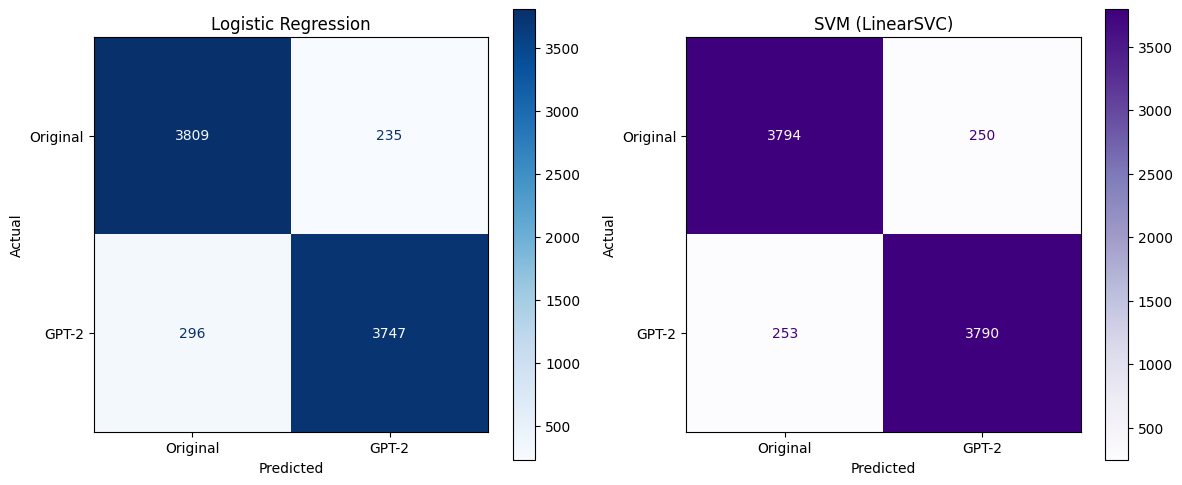

In [10]:
# Training vs Validation Accuracy
train_acc_lr = accuracy_score(y_train, logreg.predict(X_train_comb))
val_acc_lr = acc_logreg

train_acc_svm = accuracy_score(y_train, svm.predict(X_train_comb))
val_acc_svm = acc_svm

# Plot Logistic Regression vs SVM
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# LR confusion mat
ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred_logreg,
    display_labels=['Original', 'GPT-2'],
    cmap='Blues',
    ax=axes[0]
)
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# SVM confusion mat
ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred_svm,
    display_labels=['Original', 'GPT-2'],
    cmap='Purples',
    ax=axes[1]
)
axes[1].set_title("SVM (LinearSVC)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

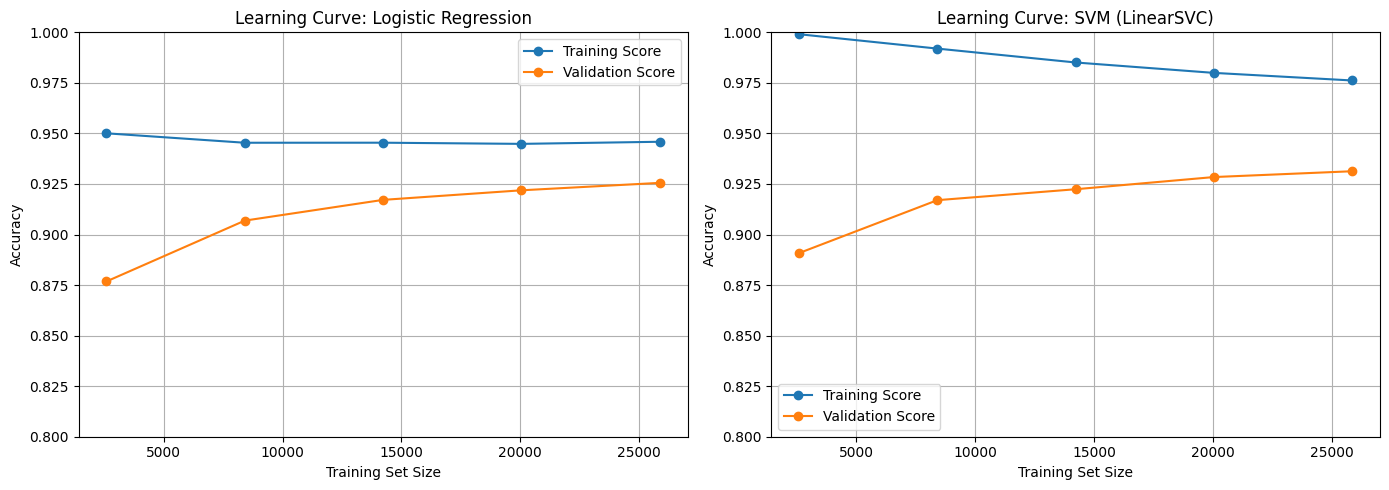

In [11]:
# Plot learning curves
def plot_learning_curve(model, X, y, title, ax):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    ax.plot(train_sizes, train_mean, 'o-', label="Training Score")
    ax.plot(train_sizes, val_mean, 'o-', label="Validation Score")
    ax.set_title(title)
    ax.set_xlabel("Training Set Size")
    ax.set_ylabel("Accuracy")
    ax.set_ylim(0.8, 1.0)
    ax.grid(True)
    ax.legend()

# Plot for both models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_learning_curve(logreg, X_train_comb, y_train, "Learning Curve: Logistic Regression", axes[0])
plot_learning_curve(svm, X_train_comb, y_train, "Learning Curve: SVM (LinearSVC)", axes[1])
plt.tight_layout()
plt.show()


In [12]:
# Prepare BERT-compatible tokenized datasets
def prepare_bert_data(tokenizer, train_texts, val_texts, y_train, y_val, max_length, batch_size):
    def tokenize(texts):
        return tokenizer(
            list(texts),
            max_length=max_length,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )

    X_train = tokenize(train_texts)
    X_val = tokenize(val_texts)

    train_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': X_train['input_ids'],
            'attention_mask': X_train['attention_mask']
        },
        y_train
    )).shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': X_val['input_ids'],
            'attention_mask': X_val['attention_mask']
        },
        y_val
    )).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset

In [13]:
# Run one BERT experiment with given parameters
def run_bert_experiment(batch_size, learning_rate, max_length=64, epochs=2, model_name='bert-base-uncased'):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    train_dataset, val_dataset = prepare_bert_data(
        tokenizer, train_df['text'], val_df['text'], y_train, y_val, max_length, batch_size
    )

    model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

    num_train_steps = len(train_dataset) * epochs

    optimizer, schedule = create_optimizer(
        init_lr=learning_rate,
        num_warmup_steps=0,
        num_train_steps=num_train_steps
    )

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = ['accuracy']
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        verbose=2
    )

    val_logits = model.predict(val_dataset).logits
    y_pred = tf.math.argmax(val_logits, axis=1).numpy()

    print(f"\n=== BERT (batch={batch_size}, lr={learning_rate}, len={max_length}) ===")
    print(classification_report(y_val, y_pred, target_names=['Original', 'GPT-2']))

    return model, tokenizer, history, y_pred, val_dataset

In [14]:
# Try different batch sizes and learning rates
results = {}
for batch in [16]:
    for lr in [2e-5, 5e-5]:
        print(f"\n--- Training BERT: batch={batch}, lr={lr} ---")
        model, tokenizer, history, y_pred, val_dataset = run_bert_experiment(
            batch, lr, max_length=64, epochs=2
        )
        acc = (y_pred == y_val).mean()
        results[(batch, lr)] = (acc, model, tokenizer, history, y_pred, val_dataset)


--- Training BERT: batch=16, lr=2e-05 ---


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
2022/2022 - 224s - loss: 0.1271 - accuracy: 0.9493 - val_loss: 0.0918 - val_accuracy: 0.9654 - 224s/epoch - 111ms/step
Epoch 2/2
2022/2022 - 151s - loss: 0.0310 - accuracy: 0.9889 - val_loss: 0.1038 - val_accuracy: 0.9676 - 151s/epoch - 75ms/step
506/506 [==============================] - 14s 21ms/step

=== BERT (batch=16, lr=2e-05, len=64) ===
              precision    recall  f1-score   support

    Original       0.99      0.94      0.97      4044
       GPT-2       0.95      0.99      0.97      4043

    accuracy                           0.97      8087
   macro avg       0.97      0.97      0.97      8087
weighted avg       0.97      0.97      0.97      8087


--- Training BERT: batch=16, lr=5e-05 ---


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
2022/2022 - 204s - loss: 0.1105 - accuracy: 0.9555 - val_loss: 0.1074 - val_accuracy: 0.9568 - 204s/epoch - 101ms/step
Epoch 2/2
2022/2022 - 147s - loss: 0.0182 - accuracy: 0.9930 - val_loss: 0.0937 - val_accuracy: 0.9748 - 147s/epoch - 73ms/step
506/506 [==============================] - 14s 21ms/step

=== BERT (batch=16, lr=5e-05, len=64) ===
              precision    recall  f1-score   support

    Original       1.00      0.95      0.97      4044
       GPT-2       0.96      1.00      0.98      4043

    accuracy                           0.97      8087
   macro avg       0.98      0.97      0.97      8087
weighted avg       0.98      0.97      0.97      8087



In [15]:
# Find the best performing setting
best_params = max(results, key=lambda x: results[x][0])
print(f"\nBest batch_size and learning rate: {best_params} with accuracy {results[best_params][0]:.4f}")
best_acc, model, tokenizer, history, y_pred, val_dataset = results[best_params]


Best batch_size and learning rate: (16, 5e-05) with accuracy 0.9748


In [16]:
# Save the best-performing BERT model and tokenizer
model.save_pretrained("bert-fake-review")
tokenizer.save_pretrained("bert-fake-review")

('bert-fake-review/tokenizer_config.json',
 'bert-fake-review/special_tokens_map.json',
 'bert-fake-review/vocab.txt',
 'bert-fake-review/added_tokens.json')

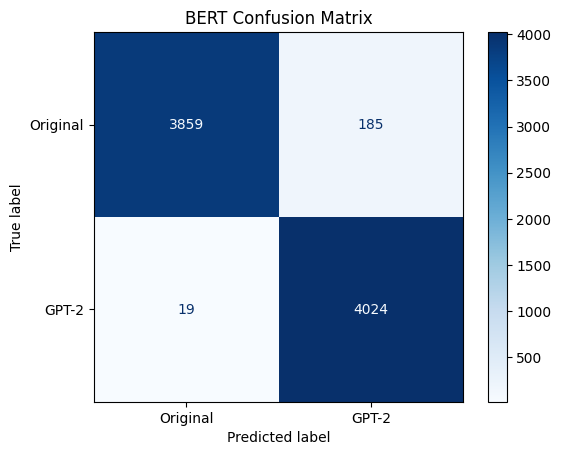

In [17]:
# BERT Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Original', 'GPT-2'])
disp.plot(cmap=plt.cm.Blues)
plt.title("BERT Confusion Matrix")
plt.show()

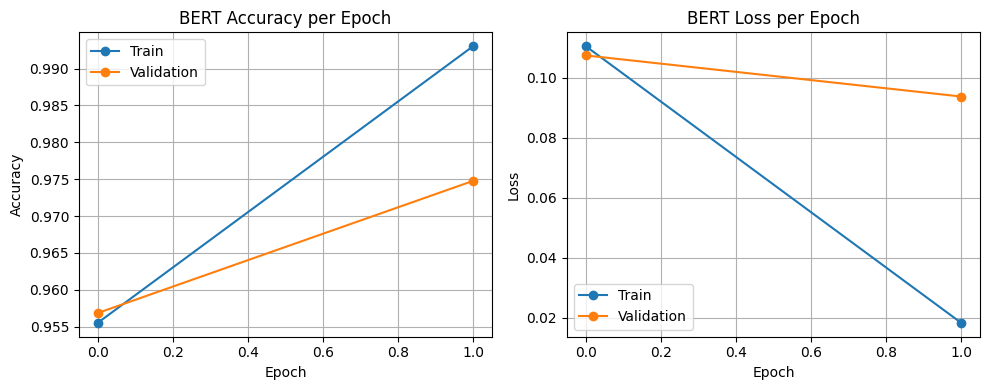

In [18]:
# Create side-by-side plots for accuracy and loss
plt.figure(figsize=(10, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation', marker='o')
plt.title('BERT Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train', marker='o')
plt.plot(history.history['val_loss'], label='Validation', marker='o')
plt.title('BERT Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'BERT'],
    'Accuracy': [acc_logreg, acc_svm, (y_pred == y_val).mean()]
})
print(summary)

                 Model  Accuracy
0  Logistic Regression  0.934339
1                  SVM  0.947581
2                 BERT  0.974774


In [20]:
category_accuracies = []
for cat in val_df['category'].unique():
    mask = val_df['category'] == cat
    acc_lr = accuracy_score(y_val[mask], y_pred_logreg[mask])
    acc_svm = accuracy_score(y_val[mask], y_pred_svm[mask])
    acc_bert = accuracy_score(y_val[mask], y_pred[mask])
    category_accuracies.append({
        'Category': cat,
        'LogReg': round(acc_lr, 3),
        'SVM': round(acc_svm, 3),
        'BERT': round(acc_bert, 3)
    })

category_df = pd.DataFrame(category_accuracies)
print(category_df.to_string(index=False))

                    Category  LogReg   SVM  BERT
            Toys_and_Games_5   0.926 0.938 0.977
              Pet_Supplies_5   0.943 0.940 0.985
Clothing_Shoes_and_Jewelry_5   0.921 0.920 0.966
                     Books_5   0.932 0.942 0.968
          Home_and_Kitchen_5   0.940 0.946 0.979
Tools_and_Home_Improvement_5   0.945 0.934 0.986
               Electronics_5   0.940 0.938 0.973
             Movies_and_TV_5   0.936 0.927 0.981
       Sports_and_Outdoors_5   0.944 0.942 0.969
              Kindle_Store_5   0.921 0.948 0.968


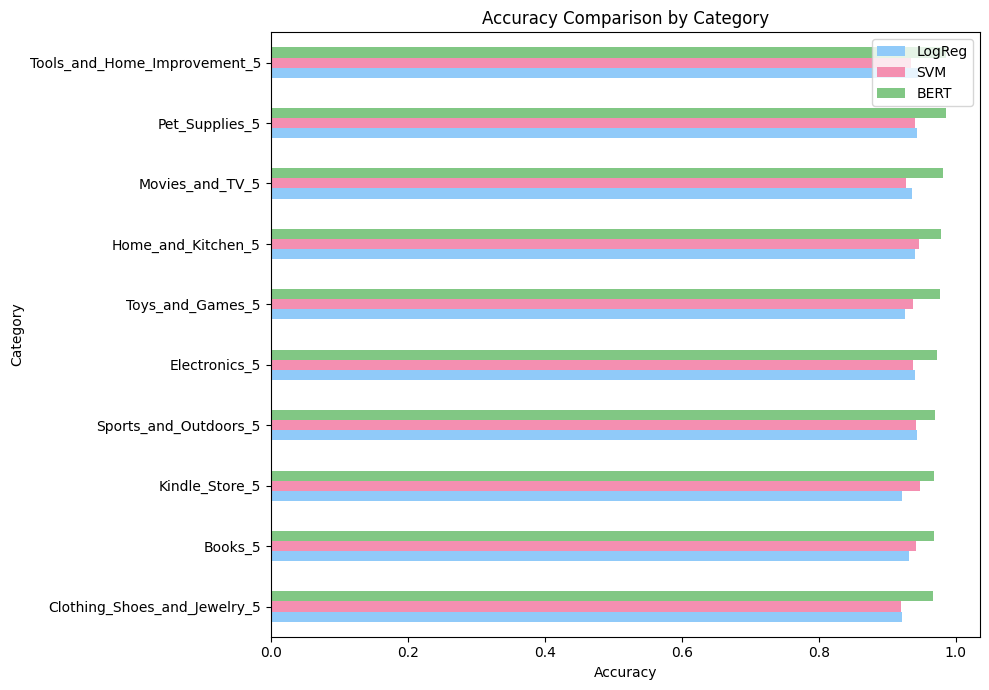

In [21]:
# Plot BERT accuracies by category
category_df_sorted = category_df.sort_values(by='BERT')

category_df_sorted.plot(
    x='Category',
    kind='barh',
    figsize=(10, 7),
    color=['#90caf9', '#f48fb1', '#81c784']
)

plt.title("Accuracy Comparison by Category")
plt.xlabel("Accuracy")
plt.tight_layout()
plt.show()

In [22]:
# Identify and display misclassified examples from the BERT model's predictions
misclassified = val_df.copy()
misclassified['pred'] = y_pred
misclassified = misclassified[misclassified['label'] != misclassified['pred']]
print("Misclassified examples:")
print(misclassified[['text', 'label', 'pred']].head(10))

Misclassified examples:
                                                    text  label  pred
29111  I can't wait to read about the Womens Murder C...      0     1
7222   This socks are simply amazing.  So soft and br...      0     1
8579   Almost useless ... a lot of lag time.  Smart p...      0     1
12187  Didn't like that they were both either married...      0     1
33917  I have always loved Snow White and the 7 Dwarf...      0     1
19856  My cat wouldn't get in the first one, so she g...      0     1
23878  GREAT READ SOMETHING DIFFERENT SHE WAS MYTHOLO...      1     0
9630   I couldn't be happier with this purchase. Ever...      0     1
21123  Great product -- well made -- easy to adjust a...      0     1
40002  I love the look and comfort of this jacket.  I...      0     1


In [23]:
# Predicting random text
def predict_review(text):
    inputs = tokenizer(
        text,
        max_length=64,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    logits = model(inputs)
    pred = tf.argmax(logits.logits, axis=1).numpy()[0]
    return 'Original' if pred == 0 else 'Fake'

print("Prediction example:", predict_review("Thank you for your hard work this semester."))

Prediction example: Original
